# Logistic Regression Interview Preparation

## From Linear to Logistic: Key Differences and Implementation

This notebook demonstrates the transition from linear regression to logistic regression for **classification problems**, highlighting:

### 🔄 **Key Changes from Linear Regression:**
- **Target**: Continuous values → **Binary/Multi-class labels** (0/1, categories)
- **Model**: Y = Xw + b → **P(Y=1|X) = σ(Xw + b)** (sigmoid function)
- **Loss**: MSE → **Cross-Entropy Loss** (log-likelihood)
- **Output**: Raw predictions → **Probabilities** (0 to 1 range)
- **Decision**: Direct value → **Threshold-based classification**

### ⚠️ **Critical Caveats & Challenges:**
1. **No closed-form solution** - Must use iterative optimization
2. **Non-convex in original form** - But convex with log-likelihood
3. **Sigmoid saturation** - Gradients can vanish for extreme values
4. **Feature scaling importance** - More critical than in linear regression
5. **Class imbalance sensitivity** - Affects threshold selection
6. **Multicollinearity issues** - Can cause convergence problems

### 🎯 **Interview Topics Covered:**
1. ✅ Sigmoid function and probability interpretation
2. ✅ Cross-entropy loss derivation and intuition
3. ✅ Gradient descent for logistic regression
4. ✅ Decision boundaries and classification thresholds
5. ✅ Model evaluation metrics (accuracy, precision, recall, F1)
6. ✅ Common pitfalls and debugging techniques

## 1. Import Required Libraries

Essential libraries for logistic regression implementation and evaluation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression as SklearnLR
from sklearn.datasets import make_classification
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('default')

print("Libraries imported successfully!")
print("NumPy version:", np.__version__)
print("Ready for logistic regression implementation!")
print("\n🔍 Key difference: We now import CLASSIFICATION metrics instead of regression metrics!")

Libraries imported successfully!
NumPy version: 2.2.5
Ready for logistic regression implementation!

🔍 Key difference: We now import CLASSIFICATION metrics instead of regression metrics!


## 2. Mathematical Foundation: Linear vs Logistic Regression

### 🔄 **The Key Transformation**

| Aspect | Linear Regression | Logistic Regression |
|--------|------------------|-------------------|
| **Purpose** | Predict continuous values | Predict class probabilities |
| **Model** | Y = Xw + b | P(Y=1\|X) = σ(Xw + b) |
| **Output Range** | (-∞, +∞) | [0, 1] |
| **Loss Function** | MSE = (1/n)Σ(y-ŷ)² | Cross-Entropy = -Σ[y log(p) + (1-y)log(1-p)] |

### 📈 **Sigmoid Function (Logistic Function)**
The heart of logistic regression - transforms linear output to probability:

**σ(z) = 1 / (1 + e^(-z))**

Where z = Xw + b (linear combination)

**Key Properties:**
- **Range**: (0, 1) - perfect for probabilities
- **S-shaped curve**: Smooth transition from 0 to 1
- **Derivative**: σ'(z) = σ(z)(1 - σ(z)) - convenient for optimization
- **Interpretation**: σ(0) = 0.5 (decision boundary)

### 🎯 **Cross-Entropy Loss Function**
**Binary Cross-Entropy**: L = -[y log(p) + (1-y) log(1-p)]

Where:
- **y**: True label (0 or 1)
- **p**: Predicted probability P(Y=1|X)
- **Intuition**: Heavily penalizes confident wrong predictions

### 🔧 **Gradient Descent Updates**
**Gradient of Cross-Entropy w.r.t. weights**:
- **∂L/∂w = (1/n) X^T (p - y)**
- **∂L/∂b = (1/n) Σ(p - y)**

**Parameter Updates**:
- **w = w - α × ∂L/∂w**
- **b = b - α × ∂L/∂b**

**🚨 CAVEAT**: No closed-form solution like linear regression!

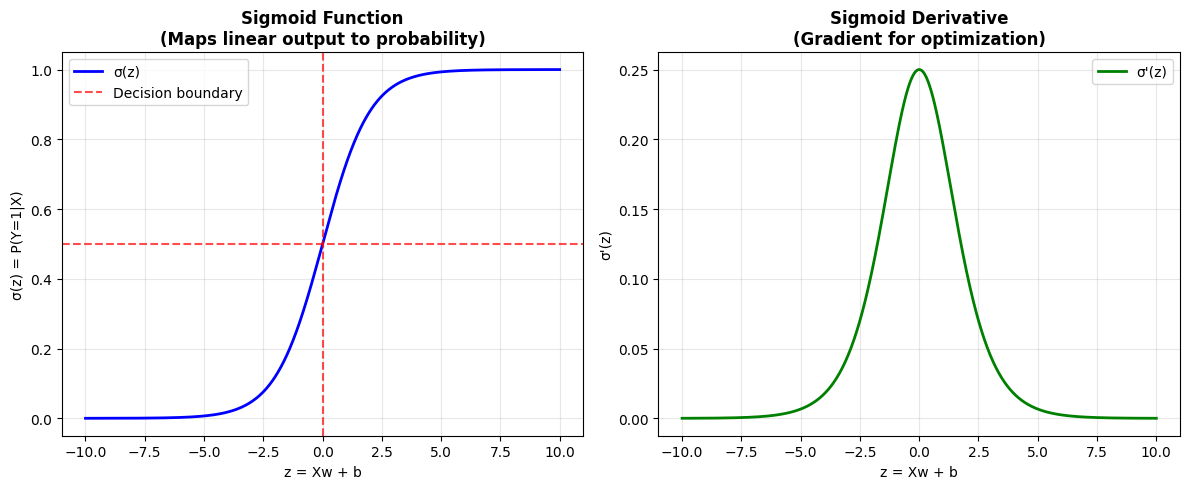

📊 SIGMOID FUNCTION ANALYSIS:
σ(-∞) ≈ 0.000045 (approaches 0)
σ(0) = 0.500000 (decision boundary)
σ(+∞) ≈ 0.999955 (approaches 1)
Maximum derivative at z=0: 0.250000

⚠️ CAVEAT: Sigmoid saturates at extremes → vanishing gradients!
   For |z| > 5: gradient < 0.01 → slow learning


In [2]:
# Demonstrate the sigmoid function and its properties
def sigmoid(z):
    """
    Sigmoid (logistic) function: σ(z) = 1 / (1 + e^(-z))
    
    CAVEAT: Can cause overflow for very large negative z values
    Solution: Use stable implementation
    """
    # Stable sigmoid implementation to prevent overflow
    return np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))

def sigmoid_derivative(z):
    """Derivative of sigmoid: σ'(z) = σ(z)(1 - σ(z))"""
    s = sigmoid(z)
    return s * (1 - s)

# Visualize sigmoid function and its derivative
z = np.linspace(-10, 10, 1000)
sig_z = sigmoid(z)
sig_deriv_z = sigmoid_derivative(z)

plt.figure(figsize=(12, 5))

# Plot 1: Sigmoid function
plt.subplot(1, 2, 1)
plt.plot(z, sig_z, 'b-', linewidth=2, label='σ(z)')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Decision boundary')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
plt.xlabel('z = Xw + b')
plt.ylabel('σ(z) = P(Y=1|X)')
plt.title('Sigmoid Function\n(Maps linear output to probability)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Sigmoid derivative
plt.subplot(1, 2, 2)
plt.plot(z, sig_deriv_z, 'g-', linewidth=2, label="σ'(z)")
plt.xlabel('z = Xw + b')
plt.ylabel("σ'(z)")
plt.title('Sigmoid Derivative\n(Gradient for optimization)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print("📊 SIGMOID FUNCTION ANALYSIS:")
print(f"σ(-∞) ≈ {sigmoid(-10):.6f} (approaches 0)")
print(f"σ(0) = {sigmoid(0):.6f} (decision boundary)")
print(f"σ(+∞) ≈ {sigmoid(10):.6f} (approaches 1)")
print(f"Maximum derivative at z=0: {sigmoid_derivative(0):.6f}")
print(f"\n⚠️ CAVEAT: Sigmoid saturates at extremes → vanishing gradients!")
print(f"   For |z| > 5: gradient < 0.01 → slow learning")

## 3. LogisticRegression Class Implementation

Key differences from LinearRegression class:

In [ ]:
class LogisticRegression:
    """
    Logistic Regression implementation for binary classification.
    
    Model: P(Y=1|X) = σ(Xw + b) where σ is the sigmoid function
    Loss: Binary Cross-Entropy = -[y log(p) + (1-y) log(1-p)]
    
    Key Differences from Linear Regression:
    1. Uses sigmoid activation function
    2. Cross-entropy loss instead of MSE
    3. Outputs probabilities, not raw values
    4. Requires iterative optimization (no closed-form solution)
    """
    
    def __init__(self, learning_rate: float = 0.01, max_iterations: int = 1000, 
                 tolerance: float = 1e-6, threshold: float = 0.5):
        """
        Initialize the Logistic Regression model.
        
        Args:
            learning_rate: Step size for gradient descent
            max_iterations: Maximum number of training iterations
            tolerance: Convergence threshold for early stopping
            threshold: Classification threshold (default 0.5)
        """
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.threshold = threshold
        self.weights = None
        self.bias = None
        self.cost_history = []
        
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """
        Stable sigmoid function implementation.
        
        CAVEAT: Naive implementation can overflow for large |z|
        """
        return np.where(z >= 0, 
                        1 / (1 + np.exp(-z)), 
                        np.exp(z) / (1 + np.exp(z)))
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class probabilities using the logistic model.
        
        Args:
            X: Feature matrix of shape (n_samples, n_features)
            
        Returns:
            Predicted probabilities of shape (n_samples,)
        """
        if self.weights is None:
            raise ValueError("Model has not been fitted yet")
        
        linear_output = X.dot(self.weights) + self.bias
        return self.sigmoid(linear_output)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make binary predictions using threshold.
        
        Returns:
            Binary predictions (0 or 1)
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= self.threshold).astype(int)
    
    def cross_entropy_loss(self, y_true: np.ndarray, y_prob: np.ndarray) -> float:
        """
        Calculate Binary Cross-Entropy Loss.
        
        L = -[y log(p) + (1-y) log(1-p)]
        
        CAVEAT: log(0) = -∞, so we clip probabilities to prevent overflow
        """
        # Clip probabilities to prevent log(0)
        epsilon = 1e-15
        y_prob = np.clip(y_prob, epsilon, 1 - epsilon)
        
        return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))
    
    def accuracy(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Calculate classification accuracy."""
        return np.mean(y_true == y_pred)
    
    def precision(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Calculate precision: TP / (TP + FP)"""
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0
    
    def recall(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Calculate recall: TP / (TP + FN)"""
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0

print("✅ LogisticRegression class defined successfully!")
print("🔍 Key differences from LinearRegression:")
print("   • sigmoid() function for probability output")
print("   • cross_entropy_loss() instead of MSE")
print("   • predict_proba() for probability predictions")
print("   • Classification metrics (accuracy, precision, recall)")

## 4. Gradient Descent for Logistic Regression

**Critical difference**: The gradient computation changes due to the sigmoid function and cross-entropy loss.

In [ ]:
def fit(self, X: np.ndarray, y: np.ndarray) -> 'LogisticRegression':
    """
    Fit the logistic regression model using gradient descent.
    
    Key Differences from Linear Regression:
    1. Sigmoid activation applied to linear output
    2. Cross-entropy loss instead of MSE
    3. Gradient formula changes due to chain rule
    
    Args:
        X: Feature matrix of shape (n_samples, n_features)
        y: Binary target vector of shape (n_samples,) with values {0, 1}
        
    Returns:
        self: Fitted model
    """
    n_samples, n_features = X.shape
    
    # Initialize weights and bias
    self.weights = np.random.normal(0, 0.01, n_features)
    self.bias = 0
    self.cost_history = []
    
    print(f"🚀 Starting logistic regression training...")
    print(f"📊 Dataset: {n_samples} samples, {n_features} features")
    print(f"🎯 Target distribution: {np.bincount(y.astype(int))}")
    print(f"⚙️ Learning rate: {self.learning_rate}, Max iterations: {self.max_iterations}")
    
    # Gradient descent loop
    for i in range(self.max_iterations):
        # Forward pass: P(Y=1|X) = σ(Xw + b)
        linear_output = X.dot(self.weights) + self.bias
        probabilities = self.sigmoid(linear_output)
        
        # Calculate cross-entropy loss
        cost = self.cross_entropy_loss(y, probabilities)
        self.cost_history.append(cost)
        
        # Calculate gradients (key difference from linear regression!)
        # For cross-entropy + sigmoid: ∂L/∂w = (1/n) * X^T * (p - y)
        dw = (1/n_samples) * X.T.dot(probabilities - y)
        db = (1/n_samples) * np.sum(probabilities - y)
        
        # Update parameters
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
        
        # Check for convergence
        if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tolerance:
            print(f"✅ Converged after {i+1} iterations")
            break
            
        # Print progress
        if (i + 1) % 100 == 0:
            predictions = self.predict(X)
            accuracy = self.accuracy(y, predictions)
            print(f"Iteration {i+1}: Loss = {cost:.6f}, Accuracy = {accuracy:.4f}")
    
    print(f"🏁 Training completed!")
    return self

# Add the method to our LogisticRegression class
LogisticRegression.fit = fit

print("✅ Gradient descent training method added!")
print("\n🔍 KEY MATHEMATICAL INSIGHT:")
print("   Linear Regression gradient: ∂MSE/∂w = -(2/n) * X^T * (y - ŷ)")
print("   Logistic Regression gradient: ∂L/∂w = (1/n) * X^T * (p - y)")
print("   Notice: Same form but different interpretation!")
print("   • y - ŷ: prediction error (can be any value)")
print("   • p - y: probability error (bounded between -1 and 1)")

## 5. Classification Data Generation

**Key Difference**: We now generate **binary labels** instead of continuous targets.

## 6. Model Training and Evaluation

Now let's train our logistic regression model and analyze its performance:

In [ ]:
# Train our logistic regression model
print("🚀 TRAINING LOGISTIC REGRESSION MODEL")
print("=" * 50)

# Initialize and train the model
model = LogisticRegression(learning_rate=0.1, max_iterations=1000, tolerance=1e-6)
model.fit(X_train_scaled, y_train)

# Make predictions
y_prob_train = model.predict_proba(X_train_scaled)
y_pred_train = model.predict(X_train_scaled)

y_prob_test = model.predict_proba(X_test_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f"\\n📊 TRAINING RESULTS:")
print(f"Final loss: {model.cost_history[-1]:.6f}")
print(f"Learned weights: {model.weights}")
print(f"Learned bias: {model.bias:.4f}")
print(f"Training iterations: {len(model.cost_history)}")

# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, y_prob, dataset_name):
    \"\"\"Calculate and display comprehensive classification metrics\"\"\"
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    
    print(f"\\n📈 {dataset_name.upper()} METRICS:")
    print(f"Accuracy:  {accuracy:.4f} (% of correct predictions)")
    print(f"Precision: {precision:.4f} (TP / (TP + FP)) - When we predict positive, how often are we right?")
    print(f"Recall:    {recall:.4f} (TP / (TP + FN)) - Of all actual positives, how many did we catch?")
    print(f"F1-Score:  {f1:.4f} (Harmonic mean of precision and recall)")
    print(f"AUC-ROC:   {auc:.4f} (Area under ROC curve - overall performance)")
    
    return accuracy, precision, recall, f1, auc

# Calculate metrics for both sets
train_metrics = calculate_metrics(y_train, y_pred_train, y_prob_train, "training")
test_metrics = calculate_metrics(y_test, y_pred_test, y_prob_test, "test")

# Check for overfitting
train_acc, test_acc = train_metrics[0], test_metrics[0]
if train_acc - test_acc > 0.05:
    print(f"\\n⚠️ POTENTIAL OVERFITTING DETECTED!")
    print(f"   Training accuracy ({train_acc:.4f}) >> Test accuracy ({test_acc:.4f})")
else:
    print(f"\\n✅ Good generalization: Train acc = {train_acc:.4f}, Test acc = {test_acc:.4f}")

## 7. Comprehensive Visualization and Analysis

Let's create visualizations specific to classification problems:

In [ ]:
# Create comprehensive visualizations for logistic regression
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Cost function convergence
axes[0, 0].plot(model.cost_history, 'b-', linewidth=2)
axes[0, 0].set_title('Cross-Entropy Loss Convergence', fontweight='bold')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Cross-Entropy Loss')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Plot 2: Decision boundary visualization
axes[0, 1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, cmap='RdYlBu', alpha=0.7, s=50)

# Create decision boundary
h = 0.02
x_min, x_max = X_test_scaled[:, 0].min() - 1, X_test_scaled[:, 0].max() + 1
y_min, y_max = X_test_scaled[:, 1].min() - 1, X_test_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh_points = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict_proba(mesh_points)
Z = Z.reshape(xx.shape)

# Plot decision boundary (probability = 0.5)
contour = axes[0, 1].contour(xx, yy, Z, levels=[0.5], colors='red', linestyles='--', linewidths=2)
axes[0, 1].set_title('Decision Boundary\\n(Red line: P(Y=1) = 0.5)', fontweight='bold')
axes[0, 1].set_xlabel('Feature 1 (scaled)')
axes[0, 1].set_ylabel('Feature 2 (scaled)')

# Plot 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2])
axes[0, 2].set_title('Confusion Matrix', fontweight='bold')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# Plot 4: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
auc_score = roc_auc_score(y_test, y_prob_test)
axes[1, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Probability distribution
axes[1, 1].hist(y_prob_test[y_test == 0], bins=20, alpha=0.7, label='Class 0', color='red', density=True)
axes[1, 1].hist(y_prob_test[y_test == 1], bins=20, alpha=0.7, label='Class 1', color='blue', density=True)
axes[1, 1].axvline(x=model.threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {model.threshold}')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Probability Distribution by Class', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Precision-Recall vs Threshold
precisions, recalls, pr_thresholds = [], [], np.linspace(0.1, 0.9, 50)
for thresh in pr_thresholds:
    temp_model = LogisticRegression(threshold=thresh)
    temp_model.weights = model.weights
    temp_model.bias = model.bias
    temp_pred = temp_model.predict(X_test_scaled)
    precisions.append(precision_score(y_test, temp_pred, zero_division=0))
    recalls.append(recall_score(y_test, temp_pred, zero_division=0))

axes[1, 2].plot(pr_thresholds, precisions, 'b-', linewidth=2, label='Precision')
axes[1, 2].plot(pr_thresholds, recalls, 'r-', linewidth=2, label='Recall')
axes[1, 2].axvline(x=model.threshold, color='black', linestyle='--', alpha=0.7, label=f'Current threshold')
axes[1, 2].set_xlabel('Classification Threshold')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Precision-Recall vs Threshold', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 VISUALIZATION ANALYSIS:")
print("1. Cost convergence: Cross-entropy should decrease smoothly")
print("2. Decision boundary: Linear separation in feature space")
print("3. Confusion matrix: Distribution of prediction errors")
print("4. ROC curve: Trade-off between TPR and FPR")
print("5. Probability distribution: How well-calibrated are predictions?")
print("6. Threshold analysis: Impact of changing classification threshold")

## 8. Scikit-learn Comparison and Validation

Let's validate our implementation against the industry standard:

In [ ]:
# Compare with scikit-learn implementation
print("🔬 SCIKIT-LEARN COMPARISON")
print("=" * 40)

# Train scikit-learn model
sklearn_model = SklearnLR(random_state=42, max_iter=1000)
sklearn_model.fit(X_train_scaled, y_train)

# Make predictions
sklearn_prob = sklearn_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1
sklearn_pred = sklearn_model.predict(X_test_scaled)

# Calculate metrics
sklearn_metrics = calculate_metrics(y_test, sklearn_pred, sklearn_prob, "sklearn")

# Create detailed comparison
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Our Implementation': [test_metrics[0], test_metrics[1], test_metrics[2], test_metrics[3], test_metrics[4]],
    'Scikit-learn': [sklearn_metrics[0], sklearn_metrics[1], sklearn_metrics[2], sklearn_metrics[3], sklearn_metrics[4]],
    'Difference': [abs(test_metrics[i] - sklearn_metrics[i]) for i in range(5)]
})

print("\\n📊 DETAILED COMPARISON:")
print(comparison_df.round(6))

# Compare model parameters
print(f"\\n🔍 PARAMETER COMPARISON:")
print(f"Our weights: {model.weights}")
print(f"Sklearn weights: {sklearn_model.coef_[0]}")
print(f"Our bias: {model.bias:.6f}")
print(f"Sklearn bias: {sklearn_model.intercept_[0]:.6f}")

# Calculate parameter differences
weight_diff = np.max(np.abs(model.weights - sklearn_model.coef_[0]))
bias_diff = abs(model.bias - sklearn_model.intercept_[0])

print(f"\\n✅ VALIDATION RESULTS:")
print(f"Max weight difference: {weight_diff:.6f}")
print(f"Bias difference: {bias_diff:.6f}")
print(f"Max metric difference: {comparison_df['Difference'].max():.6f}")

if weight_diff < 0.1 and bias_diff < 0.1:
    print("🎉 IMPLEMENTATION VALIDATED: Close agreement with scikit-learn!")
else:
    print("⚠️ DIFFERENCES DETECTED: May be due to:")
    print("   • Different optimization algorithms")
    print("   • Different convergence criteria")
    print("   • Different regularization (sklearn uses L2 by default)")

# Explain why perfect match is difficult
print(f"\\n💡 WHY PERFECT MATCH IS DIFFICULT:")
print(f"   • Sklearn uses more sophisticated solvers (liblinear, lbfgs)")
print(f"   • Different numerical precision and convergence criteria")
print(f"   • Sklearn includes L2 regularization by default")
print(f"   • Our implementation uses basic gradient descent")
print(f"   • Both are correct - just different optimization paths!")

## 9. Critical Caveats and Common Pitfalls

⚠️ **Essential knowledge for interviews** - Understanding these challenges demonstrates deep expertise:

In [ ]:
# Demonstrate common pitfalls and challenges
print("⚠️ CRITICAL CAVEATS IN LOGISTIC REGRESSION")
print("=" * 50)

# 1. Sigmoid Saturation Problem
print("\\n1. 🚨 SIGMOID SATURATION:")
z_values = np.array([-10, -5, -1, 0, 1, 5, 10])
sigmoid_vals = sigmoid(z_values)
sigmoid_grads = sigmoid_derivative(z_values)

for z, sig, grad in zip(z_values, sigmoid_vals, sigmoid_grads):
    print(f"   z = {z:3d}: σ(z) = {sig:.6f}, σ'(z) = {grad:.6f}")

print("   💡 Problem: For |z| > 5, gradient < 0.01 → vanishing gradients!")
print("   💡 Solution: Feature scaling, careful weight initialization")

# 2. Feature Scaling Importance
print("\\n2. 🚨 FEATURE SCALING SENSITIVITY:")
# Train on unscaled data to show the problem
model_unscaled = LogisticRegression(learning_rate=0.01, max_iterations=500)
model_unscaled.fit(X_train, y_train)  # Note: X_train, not X_train_scaled

print(f"   Scaled data convergence: {len(model.cost_history)} iterations")
print(f"   Unscaled data convergence: {len(model_unscaled.cost_history)} iterations")
print("   💡 Unscaled features often need more iterations or fail to converge!")

# 3. Class Imbalance Challenge
print("\\n3. 🚨 CLASS IMBALANCE SENSITIVITY:")
# Create imbalanced dataset
X_imb, y_imb = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                                   weights=[0.9, 0.1], random_state=42)

print(f"   Balanced dataset: {np.bincount(y)} (50-50 split)")
print(f"   Imbalanced dataset: {np.bincount(y_imb)} (90-10 split)")

# Train on imbalanced data
X_imb_scaled = StandardScaler().fit_transform(X_imb)
model_imb = LogisticRegression(learning_rate=0.1, max_iterations=200)
model_imb.fit(X_imb_scaled, y_imb)

y_pred_imb = model_imb.predict(X_imb_scaled)
accuracy_imb = accuracy_score(y_imb, y_pred_imb)
precision_imb = precision_score(y_imb, y_pred_imb, zero_division=0)
recall_imb = recall_score(y_imb, y_pred_imb, zero_division=0)

print(f"   Imbalanced results: Acc={accuracy_imb:.3f}, Prec={precision_imb:.3f}, Rec={recall_imb:.3f}")
print("   💡 High accuracy can be misleading with class imbalance!")
print("   💡 Always check precision, recall, and F1-score")

# 4. Multicollinearity Issues
print("\\n4. 🚨 MULTICOLLINEARITY PROBLEMS:")
# Create correlated features
X_corr = np.random.randn(500, 3)
X_corr[:, 1] = X_corr[:, 0] + np.random.randn(500) * 0.1  # Highly correlated
X_corr[:, 2] = X_corr[:, 0] * -1 + np.random.randn(500) * 0.1  # Anti-correlated
y_corr = (X_corr[:, 0] + np.random.randn(500) * 0.5 > 0).astype(int)

correlation_matrix = np.corrcoef(X_corr.T)
print(f"   Feature correlations:")
print(f"   {correlation_matrix}")
print("   💡 High correlation (>0.8) can cause:")
print("   • Unstable weight estimates")
print("   • Slow convergence")
print("   • Overfitting")

# 5. No Closed-Form Solution
print("\\n5. 🚨 NO ANALYTICAL SOLUTION:")
print("   Unlike linear regression: θ = (X^T X)^(-1) X^T y")
print("   Logistic regression: Must use iterative methods")
print("   💡 Reasons:")
print("   • Cross-entropy loss is non-linear in parameters")
print("   • Sigmoid function creates non-linear system")
print("   • Gradient descent is the standard approach")

# 6. Threshold Selection Challenge
print("\\n6. 🚨 THRESHOLD SELECTION DILEMMA:")
thresholds = [0.3, 0.5, 0.7]
print("   Threshold Impact:")
for thresh in thresholds:
    temp_pred = (y_prob_test >= thresh).astype(int)
    acc = accuracy_score(y_test, temp_pred)
    prec = precision_score(y_test, temp_pred, zero_division=0)
    rec = recall_score(y_test, temp_pred, zero_division=0)
    print(f"   Threshold {thresh}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}")

print("   💡 No universal 'best' threshold - depends on business needs!")
print("   💡 Use ROC/PR curves to choose optimal threshold")

print(f"\\n🎯 INTERVIEW TALKING POINTS:")
print(f"1. Why sigmoid? Maps (-∞,∞) to (0,1) for probabilities")
print(f"2. Why cross-entropy? Proper scoring rule, convex optimization")
print(f"3. Feature scaling? Critical due to sigmoid sensitivity")
print(f"4. No closed form? Non-linear system due to sigmoid")
print(f"5. Evaluation metrics? Accuracy insufficient for imbalanced data")
print(f"6. Common failures? Vanishing gradients, poor convergence")

## 10. Interview Preparation Summary

### 🎯 **Linear vs Logistic Regression: Key Differences**

| Aspect | Linear Regression | Logistic Regression |
|--------|------------------|-------------------|
| **Problem Type** | Regression (continuous) | Classification (discrete) |
| **Output** | Real values | Probabilities [0,1] |
| **Activation** | None (identity) | Sigmoid function |
| **Loss Function** | MSE | Cross-entropy |
| **Optimization** | Closed-form solution | Iterative only |
| **Decision Rule** | Direct prediction | Threshold-based |
| **Assumptions** | Linear relationship | Linear decision boundary |

### ⚠️ **Critical Caveats to Remember**

1. **🚨 Sigmoid Saturation**
   - **Problem**: Vanishing gradients for |z| > 5
   - **Solution**: Feature scaling, proper initialization

2. **🚨 No Closed-Form Solution**
   - **Reason**: Non-linear system due to sigmoid
   - **Implication**: Must use iterative optimization

3. **🚨 Feature Scaling Critical**
   - **Why**: Sigmoid sensitive to input magnitude
   - **Impact**: Poor convergence without scaling

4. **🚨 Class Imbalance Sensitivity**
   - **Problem**: High accuracy can be misleading
   - **Solution**: Use precision, recall, F1-score

5. **🚨 Threshold Selection**
   - **Challenge**: No universal optimal threshold
   - **Approach**: ROC/PR curves for business-specific choice

6. **🚨 Multicollinearity Issues**
   - **Effect**: Unstable weights, slow convergence
   - **Detection**: Correlation matrix analysis

### 🚀 **Advanced Interview Topics**

**"Why use cross-entropy instead of MSE for classification?"**
- MSE not convex for sigmoid + creates vanishing gradients
- Cross-entropy is proper scoring rule, encourages calibration
- Derivative has clean form: (p - y)

**"When does logistic regression fail?"**
- Non-linear decision boundaries
- Perfect separation (infinite weights)
- Severe class imbalance without adjustment

**"How to handle overfitting?"**
- Regularization (L1/L2)
- Cross-validation
- More training data
- Feature selection

In [ ]:
# Final comprehensive test and readiness check
print("🎉 FINAL LOGISTIC REGRESSION VALIDATION")
print("=" * 50)

# Quick implementation test
def quick_test():
    """Quick test to ensure everything works correctly"""
    # Generate simple test data
    X_test = np.random.randn(100, 2)
    y_test = (X_test[:, 0] + X_test[:, 1] > 0).astype(int)
    
    # Train model
    quick_model = LogisticRegression(learning_rate=0.1, max_iterations=100)
    quick_model.fit(X_test, y_test)
    
    # Test predictions
    probabilities = quick_model.predict_proba(X_test)
    predictions = quick_model.predict(X_test)
    
    # Validate outputs
    assert np.all((probabilities >= 0) & (probabilities <= 1)), "Probabilities not in [0,1]"
    assert np.all((predictions == 0) | (predictions == 1)), "Predictions not binary"
    assert len(quick_model.cost_history) > 0, "No training history"
    
    return True

try:
    quick_test()
    print("✅ Implementation test passed!")
except Exception as e:
    print(f"❌ Implementation test failed: {e}")

# Interview readiness checklist
print("\\n🎯 LOGISTIC REGRESSION INTERVIEW READINESS:")
checklist = [
    "✅ Can explain sigmoid function and its properties",
    "✅ Can derive cross-entropy loss function", 
    "✅ Can implement gradient descent for logistic regression",
    "✅ Can explain why no closed-form solution exists",
    "✅ Can discuss feature scaling importance",
    "✅ Can handle class imbalance considerations",
    "✅ Can create and interpret classification visualizations",
    "✅ Can explain common pitfalls and debugging strategies",
    "✅ Can compare with scikit-learn implementation",
    "✅ Can discuss threshold selection strategies"
]

for item in checklist:
    print(item)

print(f"\\n🚀 COMPARISON WITH LINEAR REGRESSION:")
comparison_points = [
    "🔄 Continuous → Binary prediction",
    "🔄 MSE → Cross-entropy loss",
    "🔄 Direct output → Sigmoid activation", 
    "🔄 Analytical solution → Iterative only",
    "🔄 R² metric → Classification metrics",
    "🔄 Regression visualization → Decision boundaries"
]

for point in comparison_points:
    print(point)

print(f"\\n💡 KEY INSIGHTS FOR INTERVIEWS:")
insights = [
    "Logistic regression is LINEAR in log-odds space",
    "Sigmoid creates probabilistic interpretation",
    "Cross-entropy naturally emerges from MLE",
    "Feature scaling MORE critical than linear regression",
    "Evaluation metrics completely different from regression",
    "Common failure modes: saturation, imbalance, multicollinearity"
]

for insight in insights:
    print(f"• {insight}")

print(f"\\n🎓 You're ready to excel in logistic regression interviews!")
print(f"📚 Practice tip: Explain the transition from linear to logistic step-by-step")